In [1]:
import pygame
import gymnasium as gym
from gymnasium import spaces
from typing import Tuple
import numpy as np
from stable_baselines3 import PPO
import torch as th

# Definición del entorno GoToTopLeft en una grilla de 10x10 con obstáculos alternados
class GoToTopLeftEnv(gym.Env):
    metadata = {"render.modes": ["console", "human"]}
    LEFT = 0
    RIGHT = 1
    UP = 2
    DOWN = 3

    def __init__(self, grid_size=10, obstacle_row=5):
        super(GoToTopLeftEnv, self).__init__()
        self.grid_size = grid_size
        self.obstacle_row = obstacle_row
        self.agent_pos = [grid_size - 1, grid_size - 1]  # Inicializa al agente en la esquina inferior derecha
        n_actions = 4
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.Box(
            low=0, high=self.grid_size - 1, shape=(2,), dtype=np.int32
        )

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        self.agent_pos = [self.grid_size - 1, self.grid_size - 1]  # Reposiciona al agente en la esquina inicial
        return np.array(self.agent_pos), {}

    def step(self, action):
        if action == self.LEFT:
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == self.RIGHT:
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)
        elif action == self.UP:
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == self.DOWN:
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)

        # Verificar si el agente está en una celda de obstáculo
        if self.agent_pos[0] == self.obstacle_row and self.agent_pos[1] % 2 == 0:
            reward = -5  # Penalización alta por caer en el obstáculo
            terminated = False  # El episodio no termina en entrenamiento
        else:
            # Condición de éxito: el agente llega a la posición superior izquierda (0,0)
            terminated = self.agent_pos == [0, 0]
            distance_to_goal = np.linalg.norm(np.array([0, 0]) - np.array(self.agent_pos))  # Distancia a la meta
            reward = -0.1 - distance_to_goal * 0.05  # Penalización progresiva por distancia
            if terminated:
                reward += 50  # Recompensa alta en la meta

        return np.array(self.agent_pos), reward, terminated, False, {}

# Entrenamiento del agente con el modelo PPO
env = GoToTopLeftEnv(grid_size=10, obstacle_row=5)
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device="cuda",
    n_steps=2048,  # Incremento para mejorar el horizonte de aprendizaje
    learning_rate=1e-4,  # Aprendizaje más lento para mayor estabilidad
    gamma=0.99,  # Mayor importancia a la recompensa futura
    ent_coef=0.01,  # Coeficiente de entropía para fomentar exploración
)
model.learn(total_timesteps=100000)

# Función para calcular la entropía de la política para cada celda
def compute_entropy_grid(grid_size, model):
    entropy_grid = np.zeros((grid_size, grid_size))
    for row in range(grid_size):
        for col in range(grid_size):
            state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
            with th.no_grad():
                latent = model.policy.extract_features(state_tensor)
                latent_pi = model.policy.mlp_extractor.forward_actor(latent)
                action_logits = model.policy.action_net(latent_pi)
                action_probs = th.softmax(action_logits, dim=-1)
                entropy = -th.sum(action_probs * th.log(action_probs + 1e-8)).item()
                entropy_grid[row, col] = entropy
    return entropy_grid



# Configuración de Pygame para visualizar después del entrenamiento
pygame.init()
screen = pygame.display.set_mode((500, 500))
pygame.display.set_caption("Go To Top Left - Agente Entrenado con Obstáculos")
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
GRAY = (200, 200, 200)
BLACK = (0, 0, 0)
RED = (255, 0, 0)  # Color para las casillas de obstáculos
BLOCK_SIZE = 50  # Tamaño de cada bloque en la grilla
FONT = pygame.font.SysFont(None, 18)  # Fuente para mostrar los valores Q

# Función para dibujar el entorno en Pygame con valores Q y flechas
def draw_env_with_q_and_policy(state, grid_size=10, obstacle_row=5, model=None):
    screen.fill(WHITE)
    for row in range(grid_size):
        for col in range(grid_size):
            # Marca las celdas de la fila de obstáculos en rojo en posiciones pares
            if row == obstacle_row and col % 2 == 0:
                color = RED
            elif (row, col) == (0, 0):
                color = GREEN  # Meta
            elif (row, col) == (state[0], state[1]):
                color = BLUE  # Agente
            else:
                color = GRAY  # Celdas normales
            
            pygame.draw.rect(screen, color, (col * BLOCK_SIZE, row * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

            # Predecir el valor Q para cada celda y dibujar en el centro
            if model:
                state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
                q_value = model.policy.predict_values(state_tensor).item()
                #text = FONT.render(f"{q_value:.1f}", True, BLACK)
                #text_rect = text.get_rect(center=(col * BLOCK_SIZE + BLOCK_SIZE // 2, row * BLOCK_SIZE + BLOCK_SIZE // 2))
                #screen.blit(text, text_rect)

                # Obtener la acción óptima para la celda actual y dibujar una flecha
                action, _ = model.predict(np.array([row, col]), deterministic=True)
                arrow_start = (col * BLOCK_SIZE + BLOCK_SIZE // 2, row * BLOCK_SIZE + BLOCK_SIZE // 2)
                arrow_end = arrow_start
                if action == env.UP:
                    arrow_end = (arrow_start[0], arrow_start[1] - BLOCK_SIZE // 3)
                elif action == env.DOWN:
                    arrow_end = (arrow_start[0], arrow_start[1] + BLOCK_SIZE // 3)
                elif action == env.LEFT:
                    arrow_end = (arrow_start[0] - BLOCK_SIZE // 3, arrow_start[1])
                elif action == env.RIGHT:
                    arrow_end = (arrow_start[0] + BLOCK_SIZE // 3, arrow_start[1])
                pygame.draw.line(screen, BLACK, arrow_start, arrow_end, 2)
                pygame.draw.circle(screen, BLACK, arrow_end, 3)

    # Dibujar las líneas de la cuadrícula
    for x in range(0, grid_size * BLOCK_SIZE, BLOCK_SIZE):
        pygame.draw.line(screen, BLACK, (x, 0), (x, grid_size * BLOCK_SIZE))
    for y in range(0, grid_size * BLOCK_SIZE, BLOCK_SIZE):
        pygame.draw.line(screen, BLACK, (0, y), (grid_size * BLOCK_SIZE, y))

    pygame.display.flip()

# Visualización en Pygame del agente entrenado
obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    
    draw_env_with_q_and_policy(obs, grid_size=10, obstacle_row=5, model=model)
    pygame.time.delay(500)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
            pygame.quit()
            break

    if done and reward > 0:
        pygame.time.delay(300)
        break

pygame.quit()
# Calcular entropías
entropy_grid = compute_entropy_grid(10, model)

print("Entrenamiento completado y visualización finalizada.")


pygame 2.6.1 (SDL 2.28.4, Python 3.10.15)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 530      |
|    ep_rew_mean     | -318     |
| time/              |          |
|    fps             | 1985     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 385         |
|    ep_rew_mean          | -206        |
| time/                   |             |
|    fps                  | 1368        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01

In [2]:
import torch as th
import numpy as np

def print_q_grid(grid_size, model):
    print("Valores Q aproximados en formato de cuadrícula:")
    q_grid = np.zeros((grid_size, grid_size))  # Crear una cuadrícula vacía para almacenar los valores Q
    for row in range(grid_size):
        for col in range(grid_size):
            # Crear el estado actual como tensor de PyTorch
            state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
            # Predecir el valor Q para la celda actual
            q_value = model.policy.predict_values(state_tensor).item()
            q_grid[row, col] = q_value  # Almacenar en la cuadrícula

    # Imprimir la cuadrícula
    for row in range(grid_size):
        print(" ".join(f"{q_grid[row, col]:6.2f}" for col in range(grid_size)))

# Imprimimos los valores Q en formato de cuadrícula
print_q_grid(10, model)


Valores Q aproximados en formato de cuadrícula:
 50.07  49.88  49.20  48.56  48.01  47.25  46.46  45.60  44.65  43.75
 49.89  49.26  48.56  47.96  47.21  46.46  45.63  44.70  43.81  42.99
 49.33  48.57  47.90  47.15  46.43  45.64  44.75  43.88  43.04  42.21
 48.57  47.84  47.10  46.41  45.64  44.79  43.95  43.10  42.21  41.33
 47.76  47.06  46.40  45.65  44.84  44.02  43.16  42.22  41.22  40.32
 47.01  46.40  45.71  44.91  44.07  43.18  42.20  41.13  40.10  39.26
 46.38  45.78  45.03  44.17  43.23  42.18  41.04  39.91  38.92  38.18
 45.81  45.17  44.36  43.39  42.29  41.07  39.83  38.69  37.78  37.13
 45.26  44.57  43.67  42.58  41.34  39.99  38.69  37.57  36.71  36.11
 44.71  43.97  42.97  41.79  40.44  39.02  37.68  36.54  35.67  35.06


[[1.65115982e-01 7.37776048e-04 1.94382708e-04 1.38853196e-04
  1.24654485e-04 1.20574005e-04 1.20958881e-04 1.23695121e-04
  1.27627354e-04 1.32417903e-04]
 [7.46581098e-03 2.87042499e-01 2.33846926e-03 4.15045506e-04
  2.17751192e-04 1.60415992e-04 1.35765484e-04 1.23349208e-04
  1.17260846e-04 1.14714116e-04]
 [3.87447973e-04 6.01004204e-03 6.96181297e-01 3.45876850e-02
  3.46694910e-03 9.85951046e-04 4.63417789e-04 2.84570706e-04
  2.05189761e-04 1.64142330e-04]
 [2.32983934e-04 2.93563615e-04 3.50245414e-03 1.43437371e-01
  6.68594360e-01 1.48605153e-01 2.67059766e-02 6.50414405e-03
  2.14624265e-03 9.23017098e-04]
 [2.10253347e-04 1.66249738e-04 2.96557759e-04 1.54268043e-03
  1.21157272e-02 7.72892535e-02 3.41012269e-01 6.96494102e-01
  3.86907965e-01 1.03584677e-01]
 [2.05502802e-04 1.49329906e-04 1.60205236e-04 2.90694123e-04
  7.58984010e-04 2.04650150e-03 5.22827869e-03 1.36170955e-02
  3.90061997e-02 1.24575317e-01]
 [2.04577882e-04 1.47866755e-04 1.35598413e-04 1.69648309e

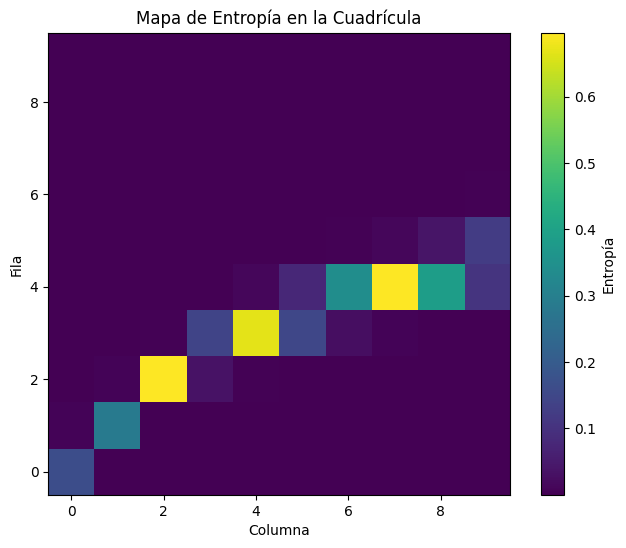

In [3]:
print(entropy_grid)
import matplotlib.pyplot as plt
import numpy as np

def plot_entropy_grid(entropy_grid):
    plt.figure(figsize=(8, 6))
    plt.imshow(entropy_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Entropía')
    plt.title('Mapa de Entropía en la Cuadrícula')
    plt.xlabel('Columna')
    plt.ylabel('Fila')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la fila 0 esté arriba
    plt.show()

# Ejemplo de uso (si entropy_grid es una matriz de ejemplo)
plot_entropy_grid(entropy_grid)
